In [16]:
import numpy as np
import cv2
from os import listdir
import tensorflow as tf
import pickle
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
#from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras import regularizers
import matplotlib.pyplot as plt
import pathlib

%matplotlib inline

In [17]:
image_gen_train = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.08,
    zoom_range=0.07,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255,
    brightness_range=[0.3, 0.6],
    width_shift_range=0.07,
    height_shift_range=0.07
)

image_gen = ImageDataGenerator(
    rescale = 1/255
)

In [18]:
# Define input directory
input_folder = pathlib.Path("split_data/")

In [27]:
batch_size = 32

training_data = image_gen_train.flow_from_directory(
    input_folder / 'train',
    class_mode="binary",
    target_size = (224, 224),
    batch_size = batch_size
)

validation_data = image_gen.flow_from_directory(
    input_folder / 'val',
    class_mode="binary",
    target_size = (224, 224),
    batch_size = batch_size
)

test_data = image_gen.flow_from_directory(
    input_folder / 'test',
    class_mode="binary",
    target_size = (224, 224),
    batch_size = batch_size,
    shuffle = False
)

Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.


In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten, BatchNormalization, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

IMAGE_SHAPE = (224, 224, 3)
CLASS_NUM = 1  

# Define the inception module
def inception_module(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1 -> 3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1 -> 5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3 -> 1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1, path2, path3, path4])

# Define the GoogLeNet architecture
def create_googlenet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    # Stage 1
    x = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    # Stage 2
    x = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

    # Stage 3
    x = inception_module(x, [64, (96, 128), (16, 32), 32]) 
    x = inception_module(x, [128, (128, 192), (32, 96), 64])  
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
    
    # Stage 4
    x = inception_module(x, [192, (96, 208), (16, 48), 64])  
    x = inception_module(x, [160, (112, 224), (24, 64), 64])  
    x = inception_module(x, [128, (128, 256), (24, 64), 64])  
    x = inception_module(x, [112, (144, 288), (32, 64), 64])  
    x = inception_module(x, [256, (160, 320), (32, 128), 128])  
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
    
    # Stage 5
    x = inception_module(x, [256, (160, 320), (32, 128), 128])  
    x = inception_module(x, [384, (192, 384), (48, 128), 128]) 
    x = GlobalAveragePooling2D()(x)
    
    # Stage 6
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output)
    return model

# Create the model
model = create_googlenet(IMAGE_SHAPE, CLASS_NUM)

# Print model summary
model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_177 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_39    │ (None, 56, 56,    │          0 │ conv2d_177[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d_39… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_178 (Conv2D) │ (None, 56, 56,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_179 (Conv2D) │ (None, 56, 56,    │    110,784 │ conv2d_178[0][0]  │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_179[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_40    │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_181 (Conv2D) │ (None, 28, 28,    │     18,528 │ max_pooling2d_40… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_183 (Conv2D) │ (None, 28, 28,    │      3,088 │ max_pooling2d_40… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_41    │ (None, 28, 28,    │          0 │ max_pooling2d_40… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_180 (Conv2D) │ (None, 28, 28,    │     12,352 │ max_pooling2d_40… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_182 (Conv2D) │ (None, 28, 28,    │    110,720 │ conv2d_181[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_184 (Conv2D) │ (None, 28, 28,    │     12,832 │ conv2d_183[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_185 (Conv2D) │ (None, 28, 28,    │      6,176 │ max_pooling2d_41… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 28, 28,    │          0 │ conv2d_180[0][0], │
│ (Concatenate)       │ 256)              │            │ conv2d_182[0][0], │
│                     │                   │            │ conv2d_184[0][0], │
│                     │                   │            │ conv2d_185[0][0]

 Total params: 5,975,601 (22.80 MB)

 Trainable params: 5,975,089 (22.79 MB)

 Non-trainable params: 512 (2.00 KB)

In [35]:
optim = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

In [36]:
epochs = 10

history = model.fit(training_data, epochs=epochs, validation_data=validation_data)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 4636s 8s/step - accuracy: 0.8250 - loss: 0.3747 - val_accuracy: 0.9373 - val_loss: 0.1852
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2321s 4s/step - accuracy: 0.9479 - loss: 0.1703 - val_accuracy: 0.9540 - val_loss: 0.1551
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2401s 4s/step - accuracy: 0.9540 - loss: 0.1506 - val_accuracy: 0.9514 - val_loss: 0.1608
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2363s 4s/step - accuracy: 0.9561 - loss: 0.1515 - val_accuracy: 0.9596 - val_loss: 0.1469
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2273s 4s/step - accuracy: 0.9568 - loss: 0.1444 - val_accuracy: 0.9603 - val_loss: 0.1702
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2332s 4s/step - accuracy: 0.9542 - loss: 0.1523 - val_accuracy: 0.9523 - val_loss: 0.1639
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2349s 4s/step - accuracy: 0.9579 - loss: 0.1424 - val_accuracy: 0.9586 - val_loss: 0.1285
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2296s 4s/step - accuracy: 0.9585 - loss: 0.1342 - 

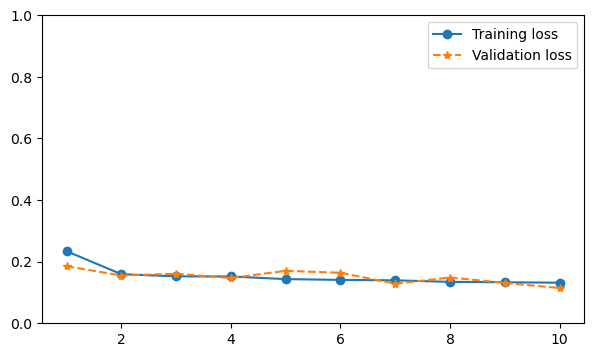

In [44]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
plt.ylim(0, 1)
ax.legend()
plt.show()

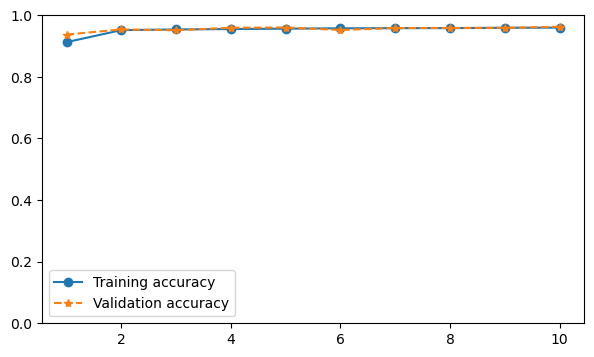

In [45]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
plt.ylim(0, 1)
ax.legend()
plt.show()

In [42]:
model.evaluate(test_data)

130/130 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.9520 - loss: 0.1378


[0.12390017509460449, 0.9610735177993774]

130/130 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step
Confusion matrix:
 [[1963  105]
 [  56 2012]]


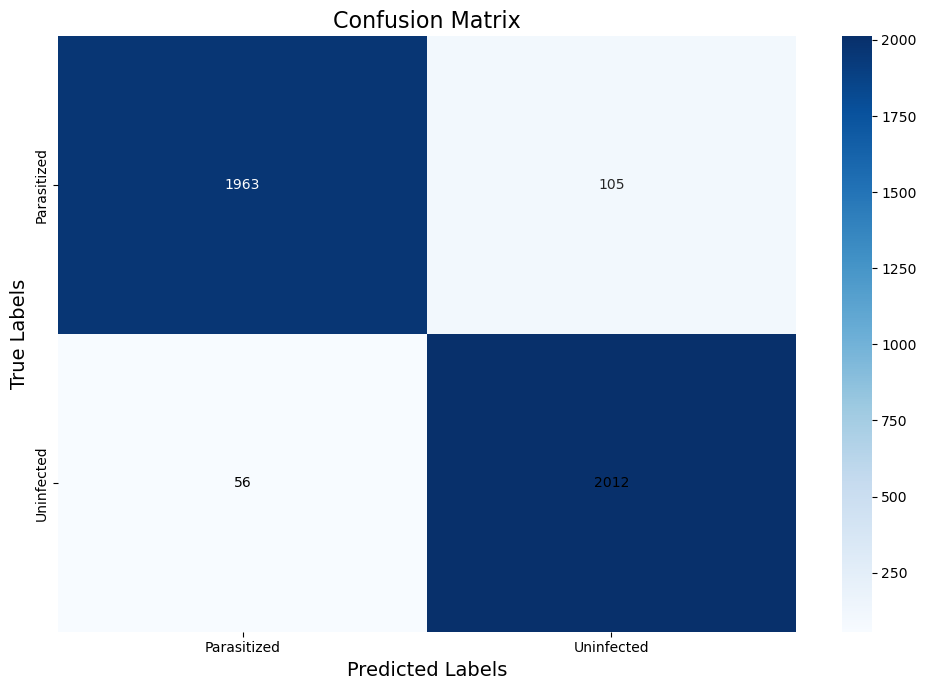

              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2068
  Uninfected       0.95      0.97      0.96      2068

    accuracy                           0.96      4136
   macro avg       0.96      0.96      0.96      4136
weighted avg       0.96      0.96      0.96      4136



In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test data
predictions = model.predict(test_data)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

# Get true classes
true_classes = test_data.classes

# Create confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print confusion matrix
print("Confusion matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)

for i, value in enumerate(conf_matrix[1]):
    plt.text(i + 0.5, 1.5, str(value), ha="center", va="center", color="black")

plt.xlabel('Predicted Labels', fontsize=14)  # Increase label font size for better visibility
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Ensure tight layout to prevent labels from overlapping
plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys()))